## 🧭 PHASE 1 — Setup & GPU Configuration

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


# 📁 PHASE 2 — Dataset Setup

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d /content/skin_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/skin_data/ham10000_images_part_2/ISIC_0

In [ ]:
import os, shutil

all_images_dir = "/content/skin_data/all_images"
os.makedirs(all_images_dir, exist_ok=True)

for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    part_path = os.path.join("/content/skin_data", part)
    for file_name in os.listdir(part_path):
        src = os.path.join(part_path, file_name)
        dst = os.path.join(all_images_dir, file_name)
        shutil.copy(src, dst)

print("✅ All images combined into:", all_images_dir)
print("Total images:", len(os.listdir(all_images_dir)))

✅ All images combined into: /content/skin_data/all_images
Total images: 10015


In [ ]:
import pandas as pd

#  Read metadata
meta = pd.read_csv("/content/skin_data/HAM10000_metadata.csv")

# Show first few rows
meta.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
from tqdm import tqdm  # progress bar

# Create a new structured folder for labeled data
base_dir = "/content/skin_data_labeled"
os.makedirs(base_dir, exist_ok=True)

# Create subfolders for each diagnosis
for label in meta['dx'].unique():
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

# Copy each image into its respective class folder
for i, row in tqdm(meta.iterrows(), total=len(meta)):
    image_id = row['image_id'] + ".jpg"
    label = row['dx']
    src = os.path.join(all_images_dir, image_id)
    dst = os.path.join(base_dir, label, image_id)
    if os.path.exists(src):
        shutil.copy(src, dst)

100%|██████████| 10015/10015 [00:22<00:00, 445.61it/s]


In [ ]:
for label in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, label)))
    print(f"{label}: {count} images")

df: 115 images
bkl: 1099 images
akiec: 327 images
nv: 6705 images
vasc: 142 images
bcc: 514 images
mel: 1113 images


# 🧹 PHASE 3 — Data Preprocessing

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import pandas as pd
import numpy as np

In [ ]:
# Paths
base_dir = "/content/skin_data_labeled"  # images organized by label folders
split_dir = "/content/skin_data_split"
os.makedirs(split_dir, exist_ok=True)

train_dir = os.path.join(split_dir, "train")
test_dir = os.path.join(split_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Stratified split by class labels, copy data into split folders
for label in os.listdir(base_dir):
    images = os.listdir(os.path.join(base_dir, label))
    train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

    for file in train_files:
        shutil.copy(os.path.join(base_dir, label, file), os.path.join(train_dir, label, file))
    for file in test_files:
        shutil.copy(os.path.join(base_dir, label, file), os.path.join(test_dir, label, file))

# Define data augmentations and normalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets with transforms
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# Calculate class weights for imbalance
labels = [sample[1] for sample in train_data.samples]
class_sample_count = np.array([labels.count(i) for i in range(len(train_data.classes))])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in labels])
samples_weight = torch.from_numpy(samples_weight).double()

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# DataLoaders using sampler to balance batches
train_loader = DataLoader(train_data, batch_size=64, sampler=sampler, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

# Check number of classes and samples
print("Classes:", train_data.classes)
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Training samples: 8010
Testing samples: 2005


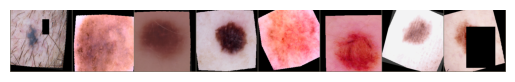

['nv', 'nv', 'nv', 'mel', 'akiec', 'nv', 'nv', 'nv']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))
print([train_data.classes[i] for i in labels[:8]])

# 🧠 Phase 4: Model Building — CNN Classifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

In [ ]:
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Replace the final fully connected layer for 7 classes (HAM10000)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 🎯 PHASE 5 — Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training completed ✅")

Epoch [1/30], Loss: 0.7376
Epoch [2/30], Loss: 0.5937
Epoch [3/30], Loss: 0.5343
Epoch [4/30], Loss: 0.4952
Epoch [5/30], Loss: 0.4550
Epoch [6/30], Loss: 0.4353
Epoch [7/30], Loss: 0.4117
Epoch [8/30], Loss: 0.3982
Epoch [9/30], Loss: 0.3819
Epoch [10/30], Loss: 0.3674
Epoch [11/30], Loss: 0.3499
Epoch [12/30], Loss: 0.3335
Epoch [13/30], Loss: 0.3319
Epoch [14/30], Loss: 0.3114
Epoch [15/30], Loss: 0.2985
Epoch [16/30], Loss: 0.2879
Epoch [17/30], Loss: 0.2828
Epoch [18/30], Loss: 0.2756
Epoch [19/30], Loss: 0.2569
Epoch [20/30], Loss: 0.2614
Epoch [21/30], Loss: 0.2465
Epoch [22/30], Loss: 0.2468
Epoch [23/30], Loss: 0.2399
Epoch [24/30], Loss: 0.2215
Epoch [25/30], Loss: 0.2204
Epoch [26/30], Loss: 0.2235
Epoch [27/30], Loss: 0.2068
Epoch [28/30], Loss: 0.1992
Epoch [29/30], Loss: 0.1993
Epoch [30/30], Loss: 0.1910
Training completed ✅


# 📊 PHASE 6 — Evaluation

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 86.98%
